**Conda environment: conda_scRNA-seq**

**Import libraries and dependencies**

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as pl
from matplotlib import font_manager
import scanpy as sc
import torch
import scvi
import scvelo as scv
import anndata
import re
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
# Matrix multiplication balancing precision and computational efficiency (options: medium-high-highest)
torch.set_float32_matmul_precision("high")

# Highest level of verbosity
sc.settings.verbosity = 3  

# Reproducibility
scvi.settings.seed = 1

# Figures
scv.set_figure_params(style="scvelo")

# Use Times New Roman as font
font_path = '/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/supp_data/misc/Times_New_Roman.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

pl.rcParams['font.family'] = 'sans-serif'
pl.rcParams['font.sans-serif'] = prop.get_name()


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Seed set to 1


In [ ]:
# Select samples
os.chdir('/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/1-2_scKB_mapping')
samples = ['0h_1_scKB', '0h_2_scKB', '2h_1_scKB', '2h_2_scKB', '4h_1_scKB', '4h_2_scKB', '10h_1_scKB', '10h_2_scKB', '1d_1_scKB', '1d_2_scKB', '4d_1_scKB', '4d_2_scKB', '7d_1_scKB', '7d_2_scKB']

In [4]:
# Read anndata objects and concatenate them
adatas = {}
for sample in samples:
    adata_path = f'/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/2-COPILOT/h5ad_files_total/{sample}_COPILOT.h5ad'
    adatas[sample] = anndata.read_h5ad(adata_path)

    print(adatas[sample])
    

adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],batch_key='sample',batch_categories=adatas.keys(),index_unique=None, join="outer")
adata.obs_names_make_unique()
del(adatas)

AnnData object with n_obs × n_vars = 8349 × 27643
AnnData object with n_obs × n_vars = 6993 × 27795
AnnData object with n_obs × n_vars = 10371 × 26845
AnnData object with n_obs × n_vars = 11971 × 27086
AnnData object with n_obs × n_vars = 9269 × 26937
AnnData object with n_obs × n_vars = 8419 × 26885
AnnData object with n_obs × n_vars = 5899 × 26313
AnnData object with n_obs × n_vars = 7830 × 26393
AnnData object with n_obs × n_vars = 88 × 24131
AnnData object with n_obs × n_vars = 6958 × 27289
AnnData object with n_obs × n_vars = 3746 × 26586
AnnData object with n_obs × n_vars = 5802 × 26469
AnnData object with n_obs × n_vars = 10134 × 27243
AnnData object with n_obs × n_vars = 10995 × 26939


In [5]:
# Create .obs "experiment"
adata.obs['batch'] = adata.obs['sample']
adata.obs['experiment'] = adata.obs['sample']
adata.obs['experiment'] = np.where(adata.obs['sample'].str.startswith('0h_'), '0h', adata.obs['experiment'])
adata.obs['experiment'] = np.where(adata.obs['sample'].str.startswith('2h_'), '2h', adata.obs['experiment'])
adata.obs['experiment'] = np.where(adata.obs['sample'].str.startswith('4h_'), '4h', adata.obs['experiment'])
adata.obs['experiment'] = np.where(adata.obs['sample'].str.startswith('10h_'), '10h', adata.obs['experiment'])
adata.obs['experiment'] = np.where(adata.obs['sample'].str.startswith('1d_'), '1d', adata.obs['experiment'])
adata.obs['experiment'] = np.where(adata.obs['sample'].str.startswith('4d_'), '4d', adata.obs['experiment'])
adata.obs['experiment'] = np.where(adata.obs['sample'].str.startswith('7d_'), '7d', adata.obs['experiment'])
adata.obs['experiment'] = adata.obs['experiment'].astype('category')

In [6]:
custom_order = ['0h', '2h', '4h', '10h', '1d', '4d', '7d']

# Ensure 'experiment' is a categorical variable
adata.obs["experiment"] = adata.obs["experiment"].astype("category")

# Reorder the categories based on the custom order
adata.obs["experiment"].cat.reorder_categories(custom_order, inplace=True)

In [7]:
print(adata)

AnnData object with n_obs × n_vars = 106824 × 30578
    obs: 'sample', 'batch', 'experiment'


In [8]:
adata.raw = adata.copy()

In [ ]:
# Remove mitochondrial, chloroplast and protoplasting-associated genes
# Define unwanted gene patterns
mito_genes = adata.var_names.str.startswith("ATMG")  # Mitochondrial genes
chloro_genes = adata.var_names.str.startswith("ATCG")  # Chloroplast genes

# Define protoplasting-induced genes
pp_genes = pd.read_csv("/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/supp_data/misc/Protoplasting_DEgene_FC2_list.txt", header=None)[0].tolist()
pp_genes_mask = adata.var_names.isin(pp_genes)  # Find matching genes

# Combine all masks
genes_to_remove = mito_genes | chloro_genes | pp_genes_mask

# Filter out these genes
adata = adata[:, ~genes_to_remove].copy()  # Keep only the desired genes

# Check the new number of genes
print(f"Remaining genes: {adata.n_vars}")

Remaining genes: 27622


In [ ]:
# select the top 5000 highly variable genes: integration with scVI
sc.pp.highly_variable_genes(adata, flavor="seurat_v3",n_top_genes=5000,batch_key='sample',subset=True)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


**scVI integration**

In [ ]:
# Non-default parameters but they were shown to effectively remove batch effects (Wang et al., 2025)
scvi.model.SCVI.setup_anndata(adata, batch_key='sample')
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [12]:
model.to_device("cuda:0")  # Moves model to the first available GPU (which is now GPU 1)
model.train(max_epochs=100, check_val_every_n_epoch=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [13]:
model.save('/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/3-1_models/scVI_correlation_analysis.pt') 
adata.write_h5ad('/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/3-2_anndata_obj/scVI_correlation_analysis.h5ad')

In [6]:
adata = anndata.read_h5ad('/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/3-2_anndata_obj/scVI_correlation_analysis.h5ad')
model = scvi.model.SCVI.load('/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/3-1_models/scVI_correlation_analysis.pt',adata)

INFO     File                                                                                                      
         /lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/3-1_models/scVI_correlation_analysis.pt/model.pt 
         already downloaded                                                                                        


In [7]:
latent = model.get_latent_representation()
adata.obsm['X_scVI'] = latent

In [8]:
adata.layers['scVI'] = model.get_normalized_expression(library_size=1e4)

In [9]:
sc.pp.neighbors(adata, use_rep='X_scVI', random_state=0)
sc.tl.umap(adata, min_dist=0.3)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:51)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:16)


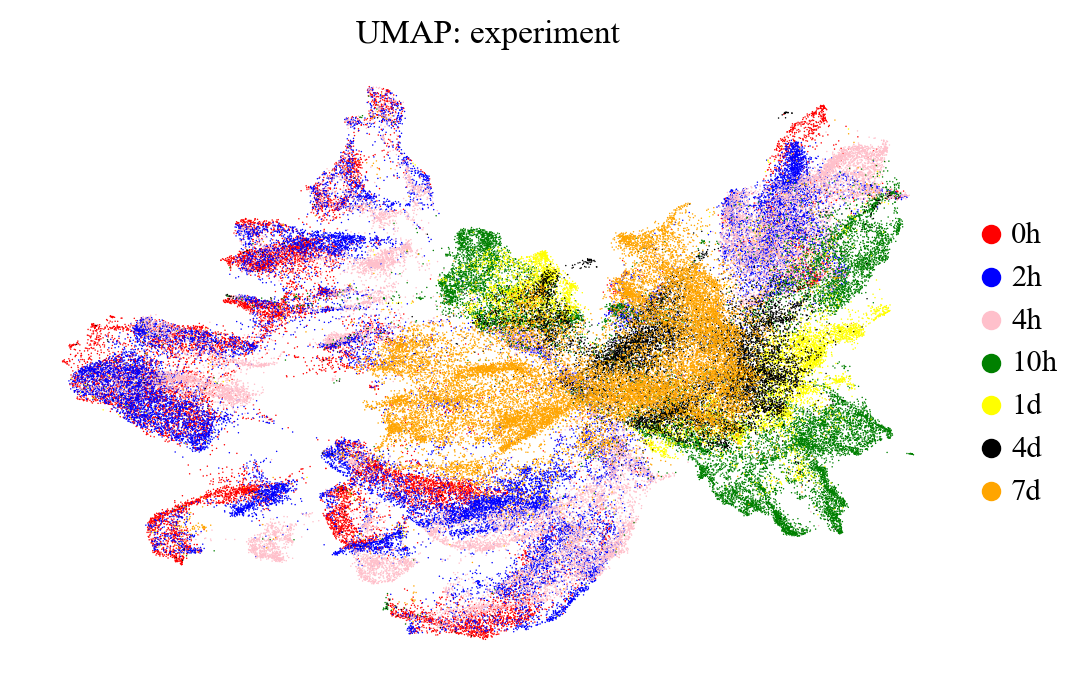

In [10]:
sc.pl.umap(adata, color="experiment", palette=['red', 'blue', 'pink', 'green', 'yellow', 'black', 'orange'], frameon=False, title="UMAP: experiment")

**Prepare for correlation analysis**

In [ ]:
# Rename samples
adata.obs['correlation_sample'] = adata.obs['sample']
adata.obs['correlation_sample'] = np.where(adata.obs['sample'].str.startswith('0h_1'), '0h_1', adata.obs['correlation_sample'])
adata.obs['correlation_sample'] = np.where(adata.obs['sample'].str.startswith('0h_2'), '0h_2', adata.obs['correlation_sample'])
adata.obs['correlation_sample'] = np.where(adata.obs['sample'].str.startswith('2h_1'), '2h_1', adata.obs['correlation_sample'])
adata.obs['correlation_sample'] = np.where(adata.obs['sample'].str.startswith('2h_2'), '2h_2', adata.obs['correlation_sample'])
adata.obs['correlation_sample'] = np.where(adata.obs['sample'].str.startswith('4h_1'), '4h_1', adata.obs['correlation_sample'])
adata.obs['correlation_sample'] = np.where(adata.obs['sample'].str.startswith('4h_2'), '4h_2', adata.obs['correlation_sample'])
adata.obs['correlation_sample'] = np.where(adata.obs['sample'].str.startswith('10h_1'), '10h_1', adata.obs['correlation_sample'])
adata.obs['correlation_sample'] = np.where(adata.obs['sample'].str.startswith('10h_2'), '10h_2', adata.obs['correlation_sample'])
adata.obs['correlation_sample'] = np.where(adata.obs['sample'].str.startswith('1d_1'), '1d_1', adata.obs['correlation_sample'])
adata.obs['correlation_sample'] = np.where(adata.obs['sample'].str.startswith('1d_2'), '1d_2', adata.obs['correlation_sample'])
adata.obs['correlation_sample'] = np.where(adata.obs['sample'].str.startswith('4d_1'), '4d_1', adata.obs['correlation_sample'])
adata.obs['correlation_sample'] = np.where(adata.obs['sample'].str.startswith('4d_2'), '4d_2', adata.obs['correlation_sample'])
adata.obs['correlation_sample'] = np.where(adata.obs['sample'].str.startswith('7d_1'), '7d_1', adata.obs['correlation_sample'])
adata.obs['correlation_sample'] = np.where(adata.obs['sample'].str.startswith('7d_2'), '7d_2', adata.obs['correlation_sample'])
adata.obs['correlation_sample'] = adata.obs['correlation_sample'].astype('category')

In [12]:
custom_order_1 = ['0h_1', '0h_2', '2h_1', '2h_2', '4h_1', '4h_2', '10h_1', '10h_2', '1d_1', '1d_2', '4d_1', '4d_2', '7d_1', '7d_2']

# Ensure 'experiment' is a categorical variable
adata.obs["correlation_sample"] = adata.obs["correlation_sample"].astype("category")

# Reorder the categories based on the custom order
adata.obs["correlation_sample"].cat.reorder_categories(custom_order_1, inplace=True)

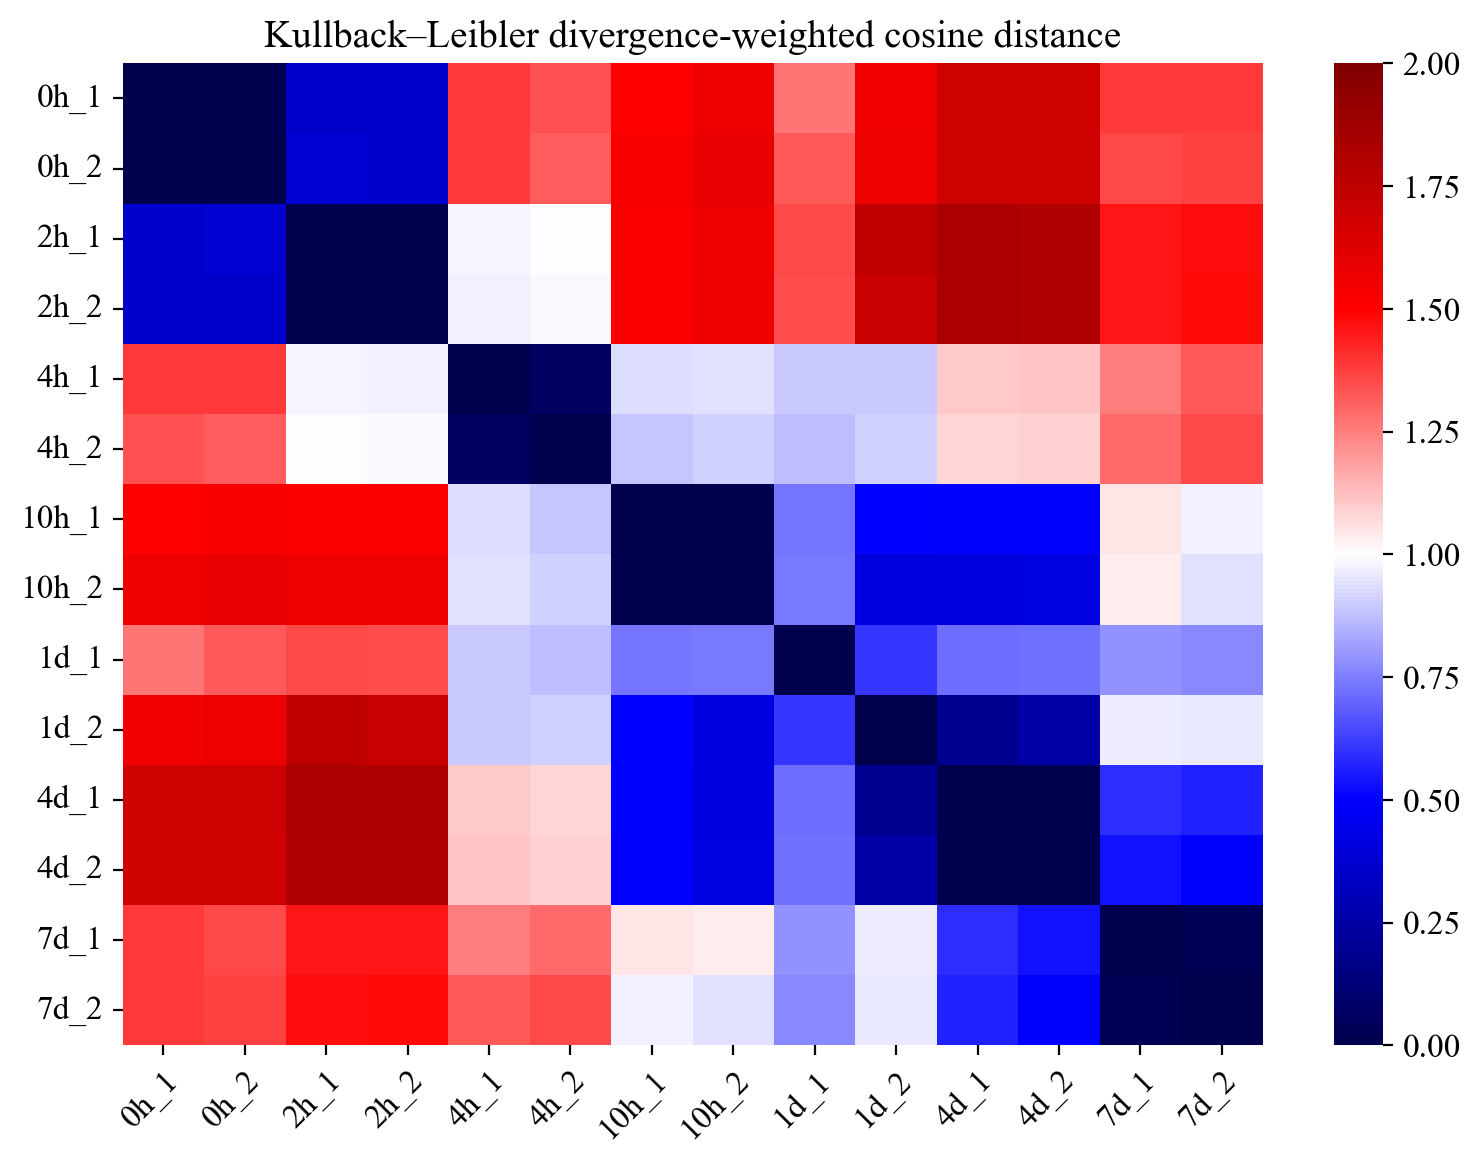

In [ ]:
# Get mean and variance (mu and sigma) from the latent representation of the scVI model
mu, sigma = model.get_latent_representation(adata=adata, return_dist=True)

# Compute the KLD per latent dimension (information content of each dimension)
kld_per_dimension = -0.5 * np.sum(
    1 + np.log(sigma) - mu**2 - sigma,
    axis=0,
)

# Normalize to get weights summing to 1
kld_weights = kld_per_dimension / np.sum(kld_per_dimension)
latent_df = pd.DataFrame(mu, index=adata.obs_names)
latent_df['sample'] = adata.obs['correlation_sample'].values

# Compute sample-wise mean embeddings (each sample's centroid in latent space)
sample_latents = latent_df.groupby('sample').mean()

# Initialize an empty matrix to hold weighted cosine similarities
samples = sample_latents.index
n = len(samples)
weighted_cosine_dist = np.zeros((n, n))

# Compute weighted cosine similarity using KLD as weights
for i in range(n):
    for j in range(n):
        x = sample_latents.iloc[i].values
        y = sample_latents.iloc[j].values
        # Weighted cosine similarity:
        dot_product = np.sum(kld_weights * x * y)
        norm_x = np.sqrt(np.sum(kld_weights * x**2))
        norm_y = np.sqrt(np.sum(kld_weights * y**2))
        similarity = dot_product / (norm_x * norm_y)
        weighted_cosine_dist[i, j] = 1 - similarity

# Convert to DataFrame
weighted_cosine_dist_df = pd.DataFrame(weighted_cosine_dist, index=samples, columns=samples)

# 1. Load the font from file — adjust the path as needed
times_new_roman = fm.FontProperties(fname="/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/supp_data/misc/Times_New_Roman.ttf")

desired_order = ['0h_1', '0h_2', '2h_1', '2h_2', '4h_1', '4h_2', '10h_1', '10h_2', '1d_1', '1d_2', '4d_1', '4d_2', '7d_1', '7d_2']
reordered_cosine_dist_df = weighted_cosine_dist_df.loc[desired_order, desired_order]

pl.figure(figsize=(8, 6))
sns.heatmap(reordered_cosine_dist_df, annot=False, cmap='seismic', center=1, vmin=0, vmax=2)
pl.title("Kullback–Leibler divergence-weighted cosine distance", fontproperties=times_new_roman, fontsize=14)
pl.xticks(rotation=45, ha='right', rotation_mode="anchor", fontproperties=times_new_roman)
pl.yticks(rotation=0, fontproperties=times_new_roman)
pl.xlabel("")
pl.ylabel("")

cbar = pl.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.ax.yaxis.set_tick_params(labelcolor='black')

# Format colorbar ticks to show decimals (e.g., 0.45, -0.55, etc.)
cbar.ax.set_yticklabels([f'{x:.2f}' for x in cbar.get_ticks()])

# Set the font of the colorbar labels to Times New Roman
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(times_new_roman)

pl.tight_layout()
pl.show()
